In [24]:
#get some library
import pandas as pd
import seaborn as sns
from Bio import SeqIO
import numpy as np
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools

from ipywidgets import widgets
from IPython.display import display
from plotly.widgets import GraphWidget

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
init_notebook_mode(connected=True)

In [25]:
#get only the gene id from
#the new TryTripDB format
def clean_id(temp_id):
    temp_id = temp_id.split(':')[0]
    if temp_id.count('.')>2:
        temp_id = '.'.join(temp_id.split('.')[0:3])
    return temp_id

#helper function to print out
#the protein removed at each threshold
def print_result(start_df_shape, shape_before, df, what):
    removed = shape_before[0]- df.shape[0]
    removed_from_beginning = start_df_shape[0]-df.shape[0]
    if removed > 0:
        print ('removed ',removed, what )  
        print ('tot ', removed_from_beginning, ' entries removed' )
        print ('---------------')
    else:
        print (what)
        print ('nothing removed')
        print ('---------------')

#remove rubbish entires from a
#maxquant output
def clean(df):  
    #remove Only identified by site
    before,start = df.shape,df.shape
    col = 'Only identified by site'
    df = df[df[col] != '+'] 
    print_result(start, before, df, col)
    
    #remove hits from reverse database
    before = df.shape
    col = 'Reverse'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
        
    #remove contaminants (mainly keratine and bsa)
    before = df.shape
    col = 'Potential contaminant'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
    
    ##remove protein groups with less thatn 2 unique peptides
    #before = df.shape
    #col = 'Peptide counts (unique)'
    #df['unique'] = [int(n.split(';')[0]) for n in df[col]]
    #df = df[df['unique'] >= 2]
    #print_result(start, before, df, col)
    return df

In [26]:
#add back the description of the proteins
desc_dict = {}
path = '../fasta/TriTrypDB-41_TbruceiTREU927_AnnotatedProteins.fasta'
with open(path, "r") as handle:
    a=0
    for record in SeqIO.parse(handle, "fasta"):
        a+=1
        temp_id = clean_id(record.id).strip()
        temp_desc = record.description.split('|')[4].strip()
        #print  (record.description.split('|'))
        if '=' in temp_desc:
            temp_desc=temp_desc.split('=')[1]
        desc_dict[temp_id]=temp_desc

desc_dict['Tb427.BES40.22']='main vsg'

In [27]:
desc_dict['Tb927.1.100']

'RNA polymerase (pseudogene), putative'

In [28]:
df = pd.read_csv('proteinGroups.txt',sep='\t')
df = clean(df)
df['Gene_id'] = [clean_id(n.split(';')[0]) for n in df['Protein IDs']]
df['Gene_desc'] = [desc_dict[n] for n in df['Gene_id']]
df.set_index('Gene_id',inplace=True)

norm_factor = df['LFQ intensity 2'].mean()+df['LFQ intensity 1'].mean()
df['fc']= (df['LFQ intensity 2']+norm_factor)/(df['LFQ intensity 1']+norm_factor)
df['fc']= np.log2(df['fc'])
df['log10_score'] = np.log10(df['Score'])
df[['Gene_desc','LFQ intensity 2','LFQ intensity 1','log10_score','fc']].to_csv('table.csv')
df[['Gene_desc','log10_score','fc']].sort_values(['fc','log10_score'], ascending=False).head(10)

removed  87 Only identified by site
tot  87  entries removed
---------------
removed  25 Reverse
tot  112  entries removed
---------------
removed  64 Potential contaminant
tot  176  entries removed
---------------


,Gene_desc,log10_score,fc
Gene_id,,,
Tb11.v5.0765,N-acetylglucosaminyl-phosphatidylinositol bios...,2.455834,3.135923
Tb927.11.10910,"40S ribosomal protein SA, putative",2.190360,2.071844
Tb927.10.560,"40S ribosomal proteins S11, putative",2.131843,1.999556
Tb927.3.3270,"ATP-dependent 6-phosphofructokinase, glycosomal",2.509619,1.922038
Tb927.11.3600,"40S ribosomal protein S4, putative",2.493862,1.897608
Tb927.10.5620,"fructose-bisphosphate aldolase, glycosomal",2.509619,1.887523
Tb927.5.3680,"GPI-GlcNAc transferase complex, PIG-H componen...",1.861630,1.831030
Tb927.10.2010,hexokinase,2.509619,1.556581
Tb927.9.12630,"glycerol kinase, glycosomal",2.509619,1.530323


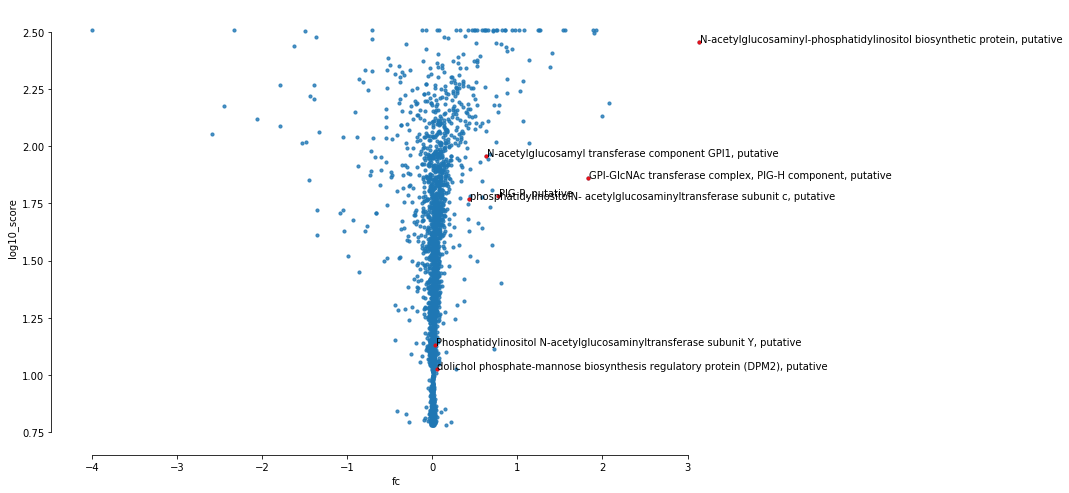

In [29]:
#selection = df[df['Score']>5]
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='fc', y='log10_score', 
            fit_reg=False, data = df,
            ax=ax, scatter_kws={'s':10})
sns.despine(offset=10, trim=True)


prots_to_annotate = [
    'Tb11.v5.0765',#'Tb927.2.1780',
    'Tb927.10.6140',
    'Tb927.5.3680',
    'Tb927.10.10110',
    'Tb927.3.4570',
    'Tb927.4.780',
    'Tb927.9.6440',
    ]
sns.regplot(x='fc', y='log10_score', 
            fit_reg=False, data = df.loc[prots_to_annotate],
            ax=ax, scatter_kws={'s':10, 'color':'red'})

for prot in prots_to_annotate:
    x = df.loc[[prot]]['fc']
    y= df.loc[[prot]]['log10_score']
    ax.annotate(desc_dict[prot],(x,y), xytext=(x+0.01,y))

def resize(arr,lower=0.0,upper=1.0):
    arr=arr.copy()
    if lower>upper: lower,upper=upper,lower
    arr -= arr.min()
    arr *= (upper-lower)/arr.max()
    arr += lower
    return arr
#temp = df[['LFQ intensity 1','LFQ intensity 2']]
#from sklearn.preprocessing import quantile_transform
#temp = pd.DataFrame(quantile_transform(temp, n_quantiles=50, random_state=0))
#temp.columns = ['LFQ intensity 1','LFQ intensity 2']
#temp.head()
df['LFQ intensity 1q']=resize(df['LFQ intensity 1'].astype(float).values,lower=1,upper=10)
df['LFQ intensity 2q']=resize(df['LFQ intensity 2'].astype(float).values,lower=1,upper=10)
df['fc2'] = np.log2(df['LFQ intensity 2q']/df['LFQ intensity 1q'])
df[['Gene_desc','log10_score','fc2']].sort_values(['fc2','log10_score'], ascending=False).head(10)
                    

np.log2(df[['LFQ intensity 1q','LFQ intensity 2q']]).plot(kind='box')

fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='fc2', y='log10_score', 
            fit_reg=False, data = df,
            ax=ax, scatter_kws={'s':10})
sns.despine(offset=10, trim=True)
prots_to_annotate = [
    'Tb11.v5.0765',#'Tb927.2.1780',
    'Tb927.10.6140',
    'Tb927.5.3680',
    'Tb927.10.10110',
    'Tb927.3.4570',
    'Tb927.4.780',
    'Tb927.9.6440',
    ]
sns.regplot(x='fc2', y='log10_score', 
            fit_reg=False, data = df.loc[prots_to_annotate],
            ax=ax, scatter_kws={'s':10, 'color':'red'})

for prot in prots_to_annotate:

    x = df.loc[[prot]]['fc2']
    y= df.loc[[prot]]['log10_score']
    ax.annotate(desc_dict[prot],(x,y), xytext=(x+0.01,y))
